In [93]:
import sys

import torch
from torch import nn
from torch.nn import functional as F
import numpy as np




class TextCNN(nn.Module):
    def __init__(self, param: dict):
        super().__init__()
        ci = 1  # input chanel size
        kernel_num = param['kernel_num'] # output chanel size
        kernel_size = param['kernel_size']
        vocab_size = param['vocab_size']
        embed_dim = param['embed_dim']
        dropout = param['dropout']
        class_num = param['class_num']
        self.param = param
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=1)
        self.conv11 = nn.Conv2d(ci, kernel_num, (kernel_size[0], embed_dim))
        self.conv12 = nn.Conv2d(ci, kernel_num, (kernel_size[1], embed_dim))
        self.conv13 = nn.Conv2d(ci, kernel_num, (kernel_size[2], embed_dim))
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(kernel_size) * kernel_num, class_num)

    @staticmethod
    def conv_and_pool(x, conv):
        # x: (batch, 1, sentence_length, embed_dim)
        x = conv(x)
        # x: (batch, kernel_num, H_out, 1)
        x = F.relu(x.squeeze(3))
        # x: (batch, kernel_num, H_out)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        #  (batch, kernel_num)
        return x

    def forward(self, x):
        # x: (batch, sentence_length)
        x = self.embed(x)
        # x: (batch, sentence_length, embed_dim)
        # TODO init embed matrix with pre-trained
        x = x.unsqueeze(1)
        # x: (batch, 1, sentence_length, embed_dim)
        x1 = self.conv_and_pool(x, self.conv11)  # (batch, kernel_num)
        x2 = self.conv_and_pool(x, self.conv12)  # (batch, kernel_num)
        x3 = self.conv_and_pool(x, self.conv13)  # (batch, kernel_num)
        x = torch.cat((x1, x2, x3), 1)  # (batch, 3 * kernel_num)
        x = self.dropout(x)
        logit = F.log_softmax(self.fc1(x), dim=1)
        # logit = F.softmax(self.fc1(x), dim=1)
        # logit = self.fc1(x)
        return logit

In [2]:
def read_data(path):
    s = []
    label = []
    with open(path, 'r') as f:
        data = f.readlines()
    for i in data:
        label.append(i.split(" ")[0])
        s.append(i.strip("\n").split(" ")[1:])
    return s, label

In [3]:
train_x, train_y = read_data('/Users/zhouzhirui/project/Task-Oriented-Chatbot/corpus/intent/fastText/demo.train.txt')
test_x, test_y = read_data('/Users/zhouzhirui/project/Task-Oriented-Chatbot/corpus/intent/fastText/demo.test.txt')

In [4]:
word2id = {"UNK": 0, "PAD": 1}
idx = 2
for s in train_x:
    for w in s:
        if w in word2id:
            pass
        else:
            word2id[w] = idx
            idx += 1

label2id = {}
label_idx = 0
for l in train_y:
    if l in label2id:
        pass
    else:
        label2id[l] = label_idx
        label_idx+=1

In [5]:
def convert_text(sentences, d, max_length=10):
    result = []
    for s in sentences:
        s = s[:max_length]
        s = ["PAD"] * (max_length - len(s)) + s
        s = [d.get(w, 0) for w in s]
        result.append(s)
    return np.array(result)

def conver_label(labels, d):
    result = [d[l] for l in labels]
    return np.array(result)

In [6]:
train_x = convert_text(train_x, word2id)
train_y = conver_label(train_y, label2id)
test_x = convert_text(test_x, word2id)
test_y = conver_label(test_y, label2id)

In [7]:
def get_batch(x, y, batch=100):
    assert x.shape[0] == y.shape[0]
    size = x.shape[0]
    idx = np.array(list(range(0, size)))
    np.random.shuffle(idx)
    x = x[idx].copy()
    y = y[idx].copy()
    n = size // batch
    for i in range(n):
        yield x[batch*i: batch*(i+1)], y[batch*i: batch*(i+1)]

In [8]:
test_x = torch.tensor(test_x)
test_y = torch.tensor(test_y)

In [138]:
def train(model, lr, epochs):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    for epoch in range(epochs):
        for step, (x, y) in enumerate(get_batch(train_x, train_y)):
            x = torch.tensor(x)
            y = torch.tensor(y)
            optimizer.zero_grad()
            logit = model(x)
            loss = F.cross_entropy(logit, y)
            # loss = F.nll_loss(logit, y)
            loss.backward()
            optimizer.step()
            if step % 100 == 0:
                model.eval()
                eval_logit = model(test_x)
                eval_loss = F.cross_entropy(eval_logit, test_y)
                model.train()
                print("epoch: {:>2}, step: {:>4} ,train loss: {:.6f}, eval loss: {:.6f}".format(epoch, step, loss, eval_loss))

In [139]:
textCNN_param = {
    "vocab_size": len(word2id),
    "embed_dim": 40,
    "class_num": len(label2id),
    "kernel_num": 16,
    "kernel_size": [3, 4, 5],
    "dropout": 0.5,
}

model = TextCNN(textCNN_param)

In [140]:
train(model, 0.01, 4)
train(model, 0.001, 6)
# train(model, 0.0001, 4)
# train(model, 0.00001, 2)

epoch:  0, step:    0 ,train loss: 4.477167, eval loss: 4.021335
epoch:  0, step:  100 ,train loss: 1.443769, eval loss: 0.983097
epoch:  0, step:  200 ,train loss: 0.954692, eval loss: 0.652551
epoch:  0, step:  300 ,train loss: 0.638155, eval loss: 0.524966
epoch:  1, step:    0 ,train loss: 0.514146, eval loss: 0.460144
epoch:  1, step:  100 ,train loss: 0.721711, eval loss: 0.420159
epoch:  1, step:  200 ,train loss: 0.815014, eval loss: 0.392086
epoch:  1, step:  300 ,train loss: 0.485019, eval loss: 0.383653
epoch:  2, step:    0 ,train loss: 0.676553, eval loss: 0.354957
epoch:  2, step:  100 ,train loss: 0.292083, eval loss: 0.349564
epoch:  2, step:  200 ,train loss: 0.656120, eval loss: 0.352064
epoch:  2, step:  300 ,train loss: 0.283528, eval loss: 0.335862
epoch:  3, step:    0 ,train loss: 0.396631, eval loss: 0.334483
epoch:  3, step:  100 ,train loss: 0.588300, eval loss: 0.329411
epoch:  3, step:  200 ,train loss: 0.537329, eval loss: 0.336878
epoch:  3, step:  300 ,tr

In [141]:
model.eval()
y_pred = model(test_x)
c = 0
for idx, i in enumerate(torch.argmax(y_pred, 1)):
    if test_y[idx] == i:
        c += 1
print(c / len(test_y))

0.9419343131917982


In [6]:
d = {"a": 1, "b": 3, "c":2}

In [7]:
d

{'a': 1, 'b': 3, 'c': 2}

In [12]:
sorted(d.items(), key=lambda x: x[1], reverse=False)

[('a', 1), ('c', 2), ('b', 3)]

/home/zhouzr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


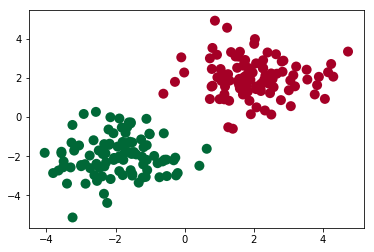

In [13]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# make fake data
n_data = torch.ones(100, 2)
x0 = torch.normal(2*n_data, 1)      # class0 x data (tensor), shape=(100, 2)
y0 = torch.zeros(100)               # class0 y data (tensor), shape=(100, 1)
x1 = torch.normal(-2*n_data, 1)     # class1 x data (tensor), shape=(100, 2)
y1 = torch.ones(100)                # class1 y data (tensor), shape=(100, 1)
x = torch.cat((x0, x1), 0).type(torch.FloatTensor)  # shape (200, 2) FloatTensor = 32-bit floating
y = torch.cat((y0, y1), ).type(torch.LongTensor)    # shape (200,) LongTensor = 64-bit integer

# torch can only train on Variable, so convert them to Variable
x, y = Variable(x), Variable(y)

# draw the data
plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=y.data.numpy(), s=100, lw=0, cmap='RdYlGn')
plt.show()

In [15]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.out = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.out(x)
        return x

net = Net(n_feature=2, n_hidden=10, n_output=2)     # define the network
print(net)  # net architecture

Net(
  (hidden): Linear(in_features=2, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=2, bias=True)
)


In [16]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.02)
loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted

for t in range(100):
    out = net(x)                 # input x and predict based on x
    loss = loss_func(out, y)     # must be (1. nn output, 2. target), the target label is NOT one-hotted

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients

In [19]:
out.shape

torch.Size([200, 2])

In [20]:
y.shape

torch.Size([200])

/home/zhouzr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


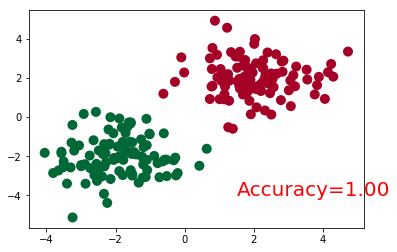

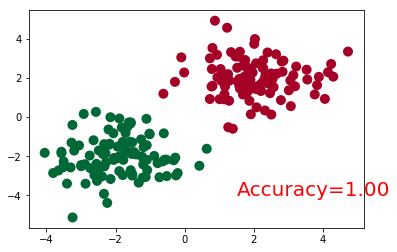

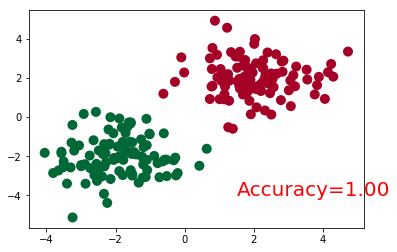

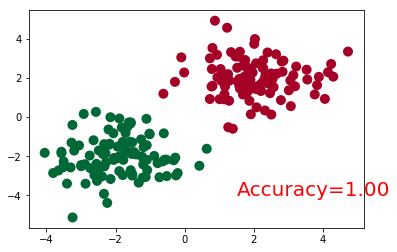

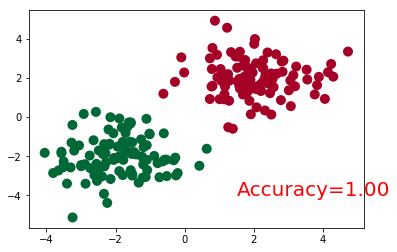

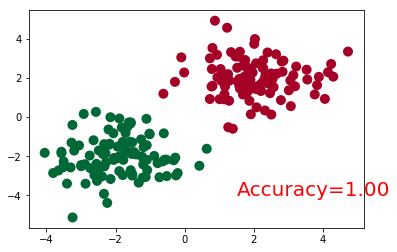

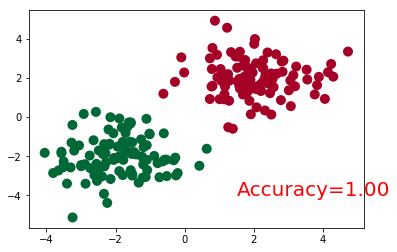

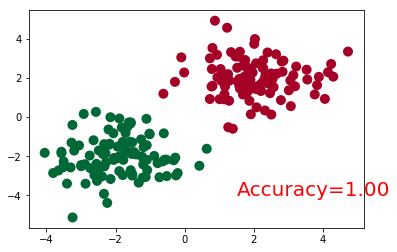

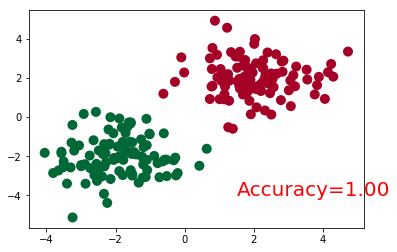

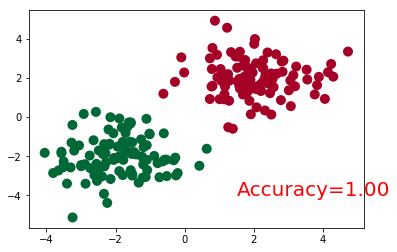

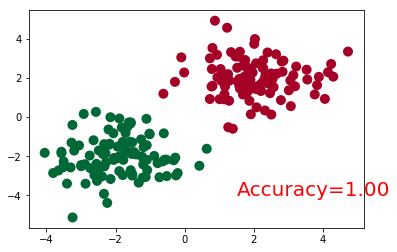

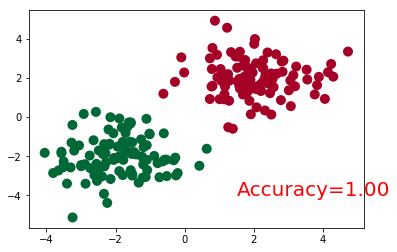

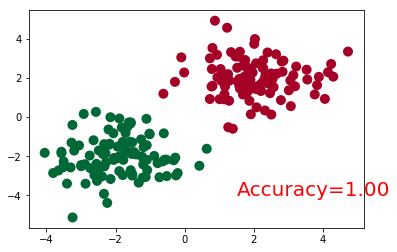

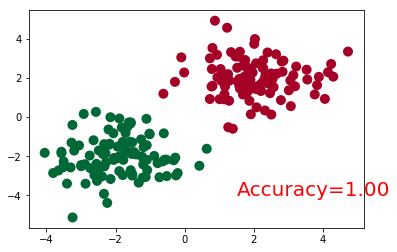

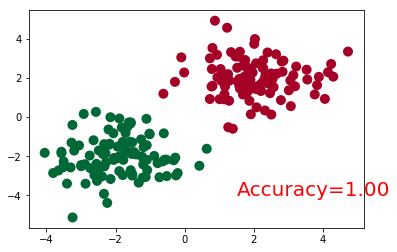

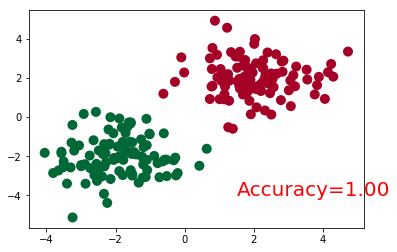

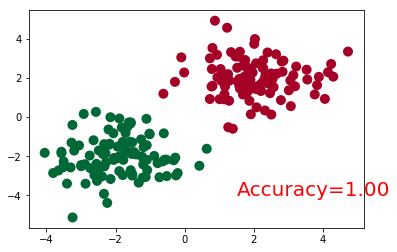

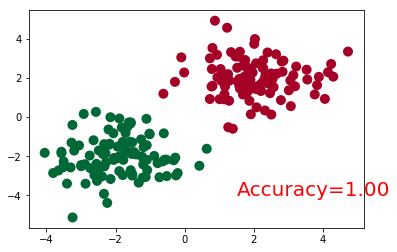

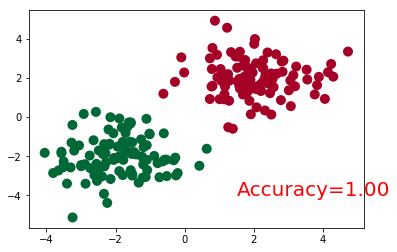

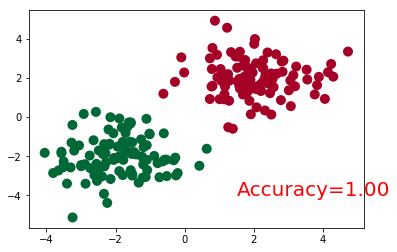

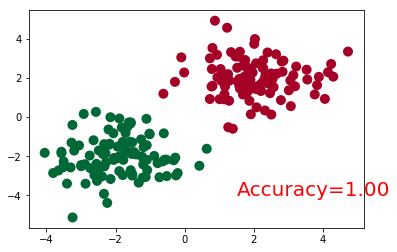

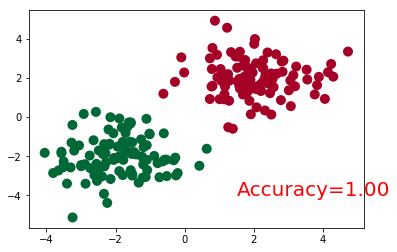

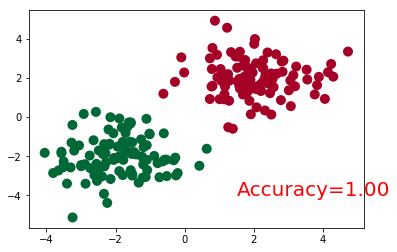

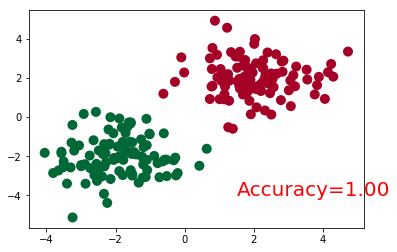

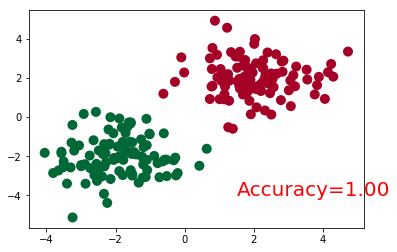

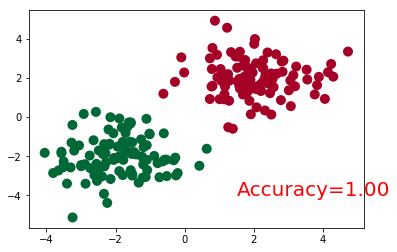

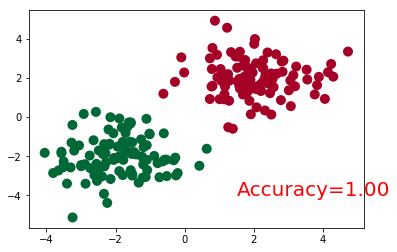

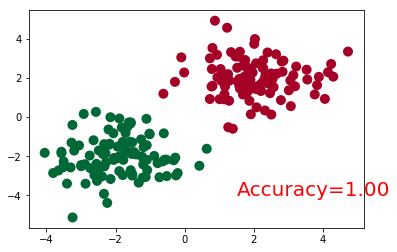

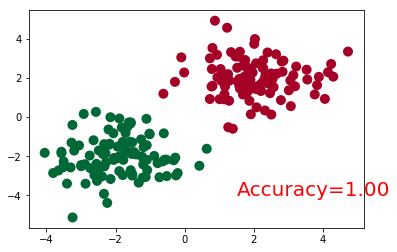

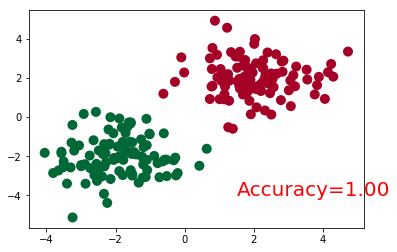

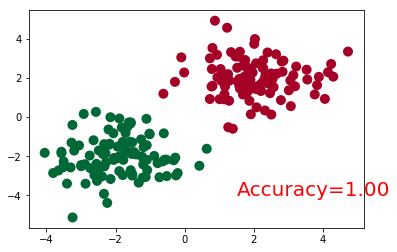

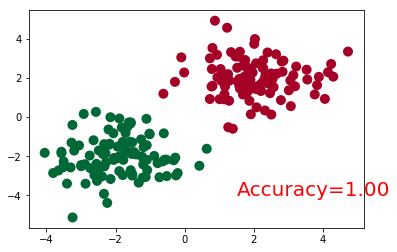

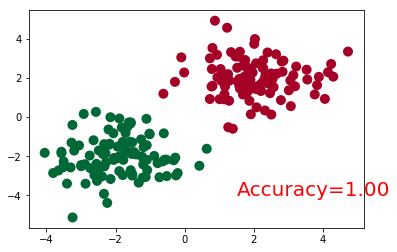

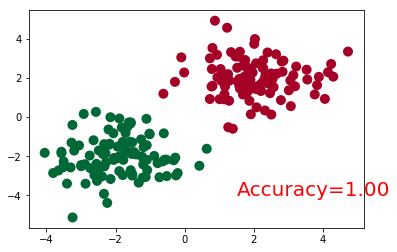

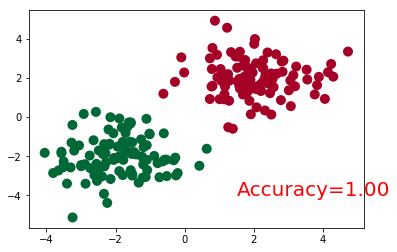

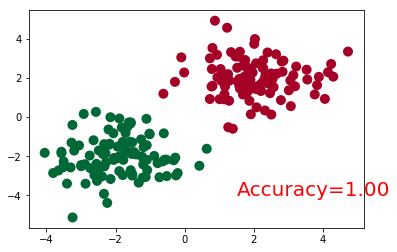

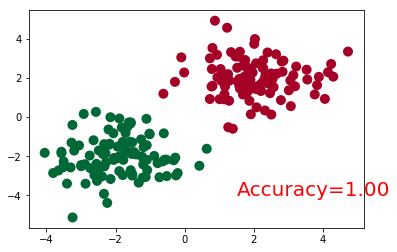

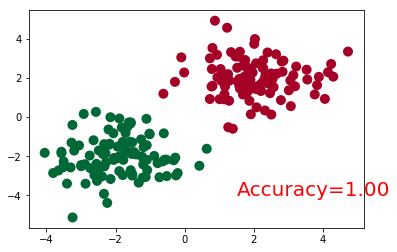

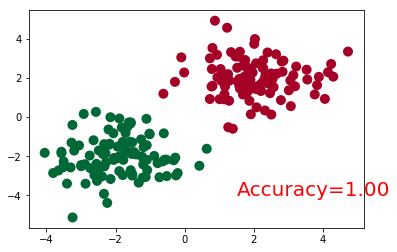

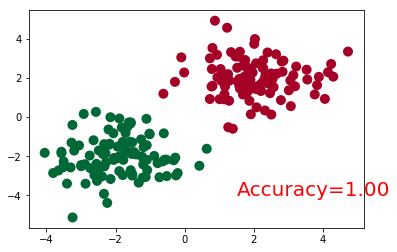

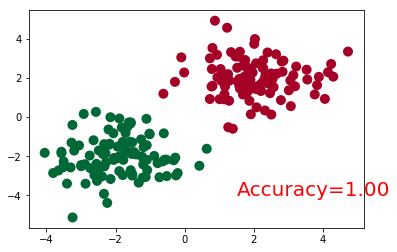

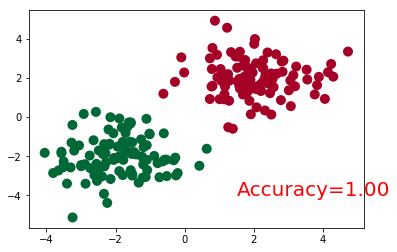

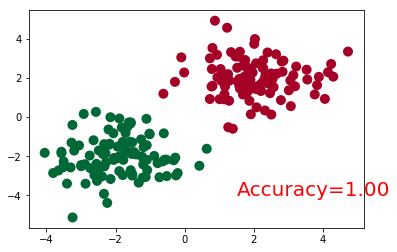

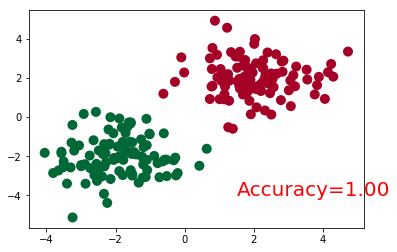

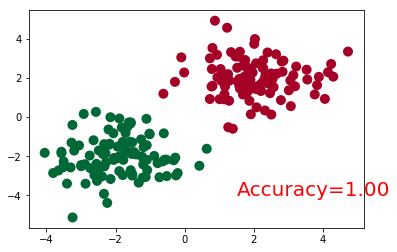

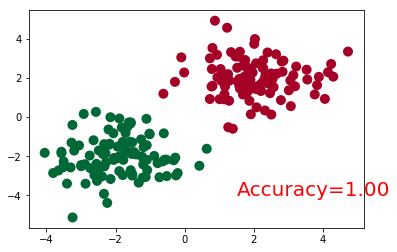

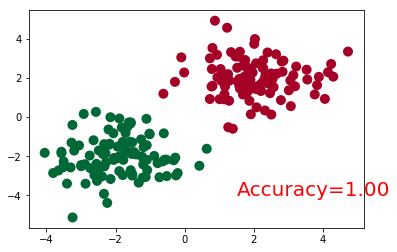

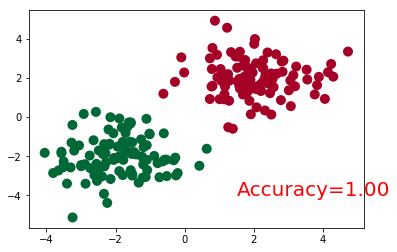

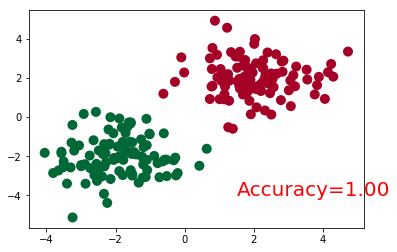

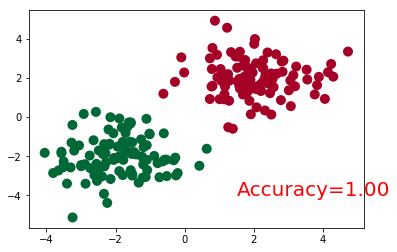

In [17]:
plt.ion()   # something about plotting

for t in range(100):
    ...

    if t % 2 == 0:
        # plot and show learning process
        plt.cla()
        prediction = torch.max(F.softmax(out), 1)[1]
        pred_y = prediction.data.numpy().squeeze()
        target_y = y.data.numpy()
        plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=pred_y, s=100, lw=0, cmap='RdYlGn')
        accuracy = sum(pred_y == target_y)/200.
        plt.text(1.5, -4, 'Accuracy=%.2f' % accuracy, fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)

plt.ioff()
plt.show()